# I239 機械学習
##    前半分レポート
- 氏名：懸樋亮一<br>
- 学生番号：2030025<br>
- 提出日：2023/09/24
- 提出期限：2023/09/24

MNISTをデータセットとし、各種教師有り学習アルゴリズムによるクラスタリングを実施する。

今回用いる教師有り学習アルゴリズムは

- Random Forest
- Support Vector Machine
- Convolutional Neural Network

の３つである。ただし、Random Forestについては、画像データをそのまま分類器にかけた場合と、画像より特徴量を抽出した場合について、それぞれ分類タスクを実行した。

## Random Forest
---
### 画像データを学習データとして用いた場合

まず最初に学習データとしてMNISTの画像データをそのまま利用した場合の分類精度を見る。その後、画像より特徴量を抽出し、その特徴量を用いて分類をする。特徴量としてはHOGとGLCMを用いる。最後に画像データをそのまま用いた場合と特徴量を用いた場合で分類精度について比較する。

In [1]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from random_forest import RandomForestModel

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Test Accuracy: 0.967
Saving model to: random_forest_model.joblib


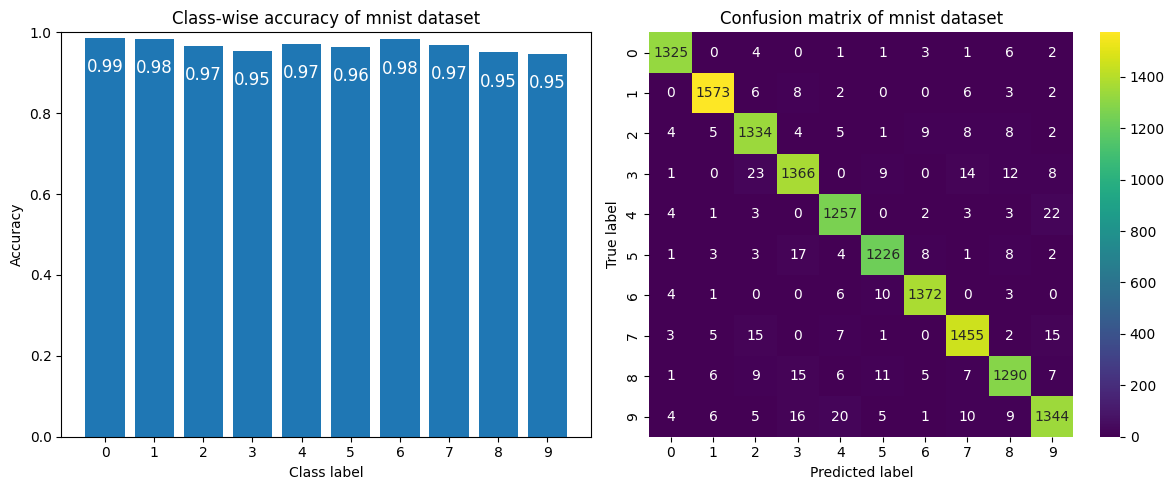

In [14]:
rf = RandomForestModel()
rf.run()

生画像をそのままRandom Forestの学習データとして用いた場合の、テストデータに対するAccuracyの値は97%となった。

ちなみに、MNISTのデータは下に示すような28x28ピクセルで、256諧調を持つグレースケール画像である。

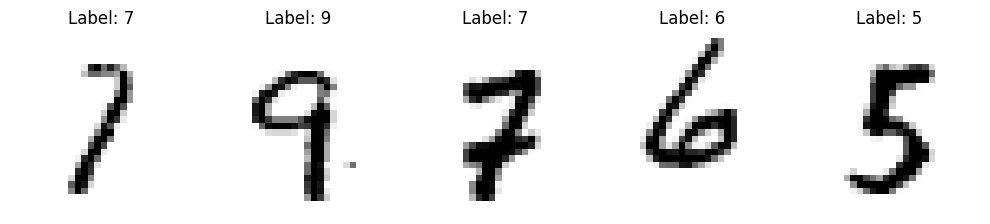

In [5]:
rf.plot_images()

### HOG

次に、MNISTの画像データよりHistogram of Oriented Gradients (**HOG**)を特徴量として算出し、HOGの値を用いて画像を分類することを考える。HOGは画像の局所的な勾配方向の情報をヒストグラムとして表現した特徴量である。

各数字毎に特徴的な勾配が存在すると考え、この勾配情報を用いることで、分類が可能となると期待して実施してみたものになる。

実際の実行結果は以下の通りである。

勾配情報を用いることで、分類精度が向上することを期待したのだが、分類精度的にはほぼ変わらないか、むしろ微小な劣化が見られたような結果となっている。当初の想定とは異なり、生画像よりも良好な分類結果とはならなかったが、その理由としては

- 画像の勾配情報を用いている為に元の画像よりも情報量が小さくなっている。
- Scikit-learnのHOGモジュールはハイパーパラメータをいくつか持っているが、いくつかの条件でグリッドサーチしてよさそうなものを選択しただけの為、ハイパーパラメータが最適ではない可能性がある。

といった事が考えられる。

In [11]:
%autoreload 2
from hog_random_forest import HOGRandomForestModel

100
Test Accuracy: 0.966
Saving model to: random_forest_model_hog.joblib


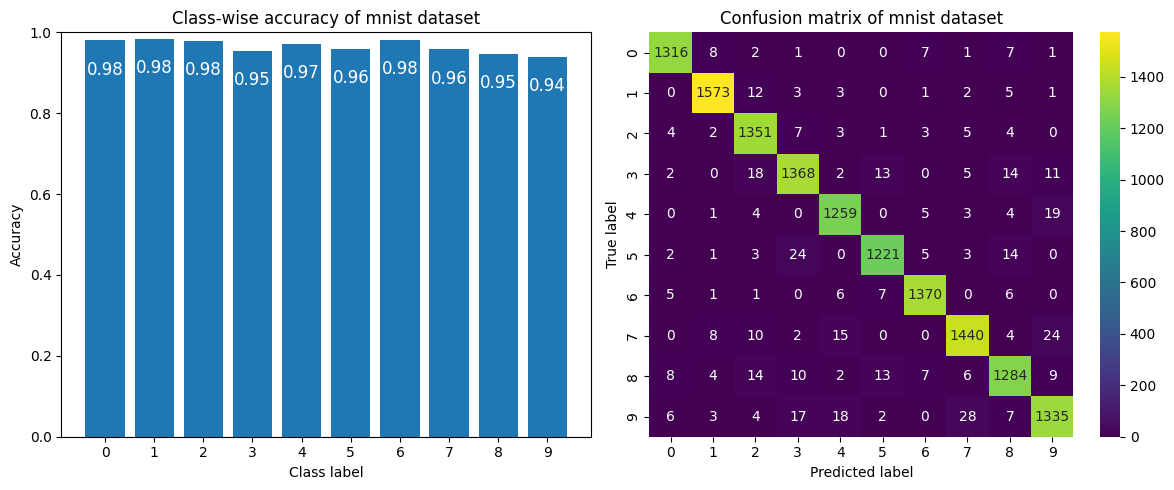

In [13]:
hog_rf = HOGRandomForestModel()
hog_rf.run()

以下の画像は、生画像データと、それに対応するHOG画像を上下に並べてプロットしたものになる。勾配情報を求める際に画像を区分けして、その区域ごとに特徴量を抽出している為、情報量としては少なくなっている事が画像より推測される。その割には生データを用いた場合と比べて分類精度にほぼ差が無いのは、区域ごとに算出した勾配情報を分類に用いることで、文字のＸ方向・Ｙ方向へのシフトに対しては、ロバストになっていると考えられ、それらがバランスして、結果的に同程度の分類精度となったのではないかと考える。

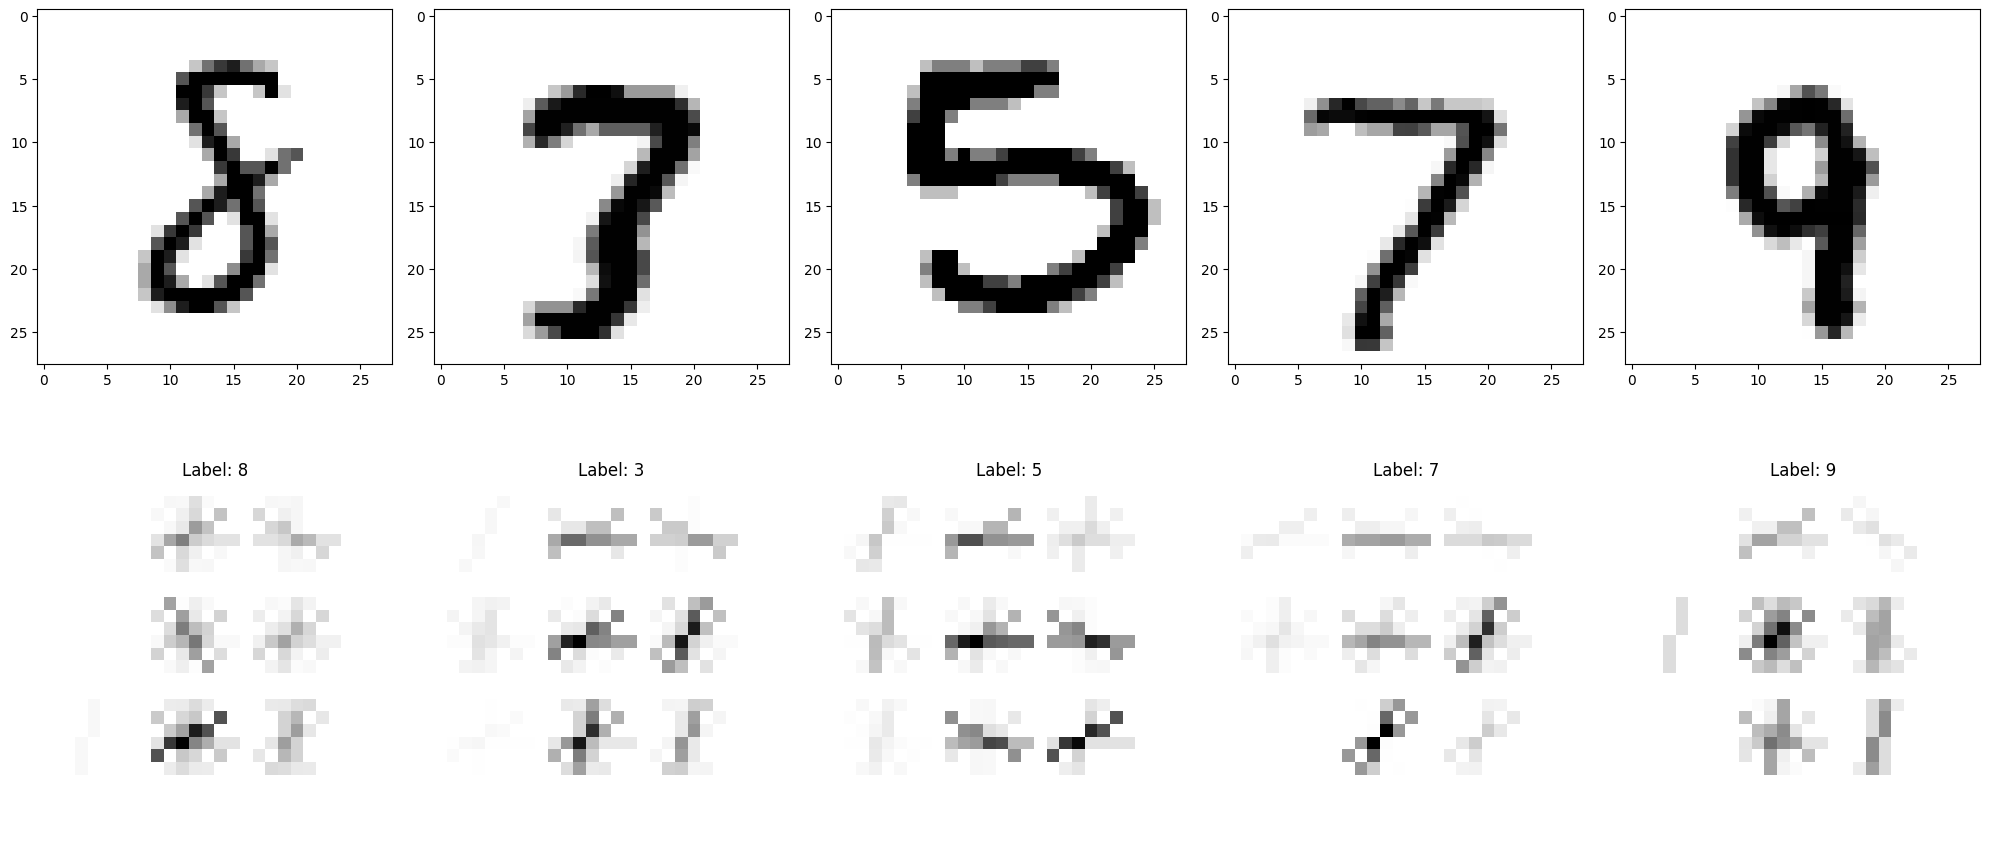

In [62]:
hog_rf.plot_images()

### GLCM

さらに特徴量としてグレイレベル共起行列(Gray Level Co-occurrence Matrix：GLCM)より抽出したテクスチャ特徴量を用いて画像の分類を行ってみる。分類器としては引き続きRandom Forestを用いることとする。

In [15]:
from GLCM_random_forest import GLCMRandomForestModel
glcm_rf = GLCMRandomForestModel()

結果は以下の通りで、分類精度はかなり下がってしまった。全く分類できていないわけではないので、GLCMから求めたテクスチャ特徴量も何かしらのパターンの特徴を捕まえているのだと思われる。テクスチャ解析はその名の通り、画像のテクスチャの違いをとらえるために使われるので、いわゆる模様的な意味でのパターンの違いが画像間に存在していない場合には、特徴量として用いる事が不適切なのだと考えられる。つまり、今回の0~9までの数値の画像は、テクスチャとしては均質に近い為、テクスチャ特徴量を用いた分類手法にははまらなかったものと考える。

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Saving model to: random_forest_model_glcm.joblib


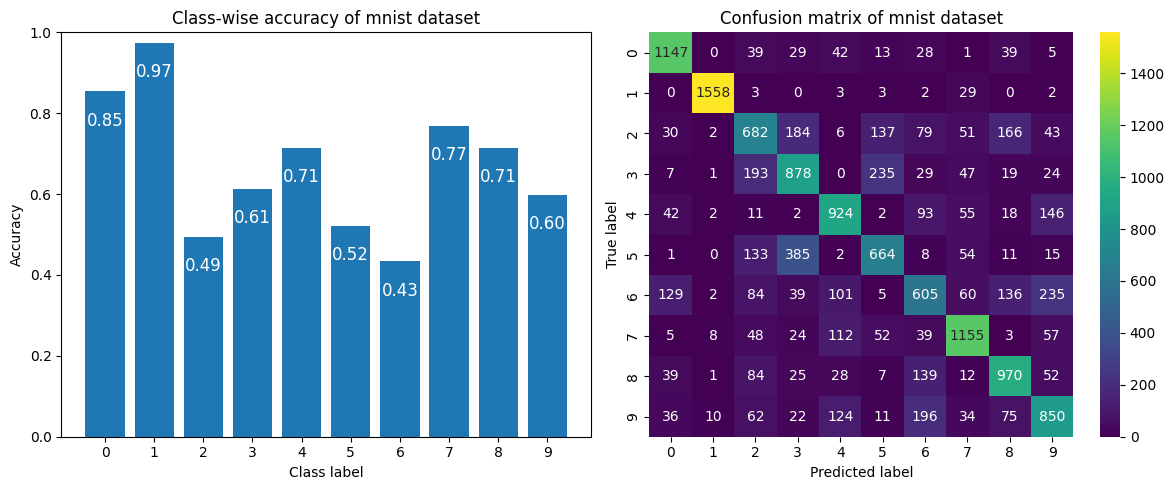

In [16]:
glcm_rf.run()

In [18]:
%autoreload 2
from support_vector_machine import SVMModel 

## Support Vector Machine

---

次にSupport Vector Machineを用いてMNISTの分類問題を解いてみる。ここでは判別関数には線形関数と非線形関数を用い、マージンとしてはソフトマージンを用いることにした。具体的には、カーネルとして`linear`と`rbf`を用い、また、正則化パラメータ$C$は$C=10$とした。これはいくつかの条件を試してみて、よさそうなものをラフに選択したものである。

まずは判別関数に線形判別関数を用いた場合の結果を示す。正則化パラメータは先に示した通り$C=10$を用いている。

Test Accuracy: 0.924
Saving model to svm_linear_10_model.joblib


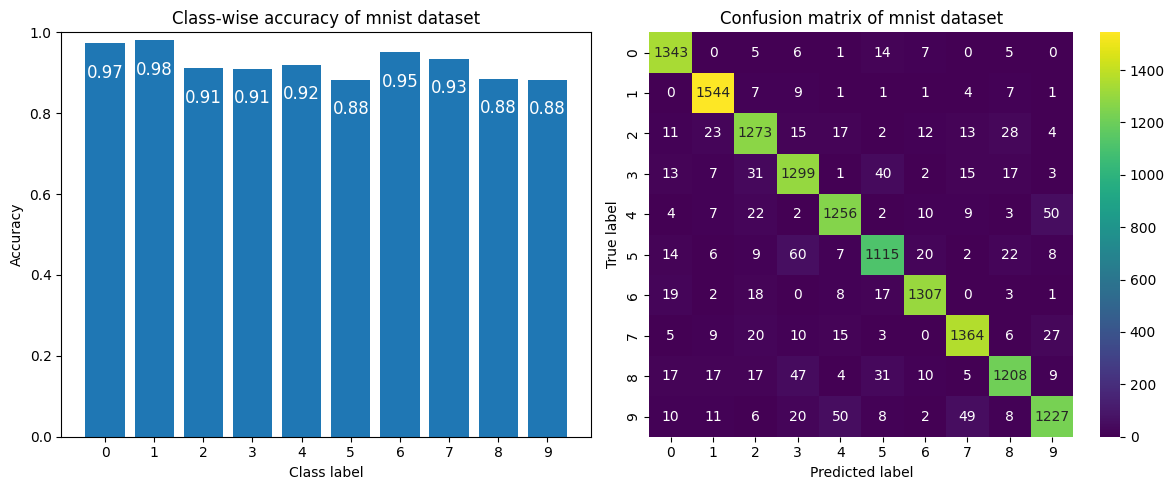

In [19]:
svm = SVMModel(kernel='linear', C=10)
svm.run()

次に判別関数にRBF(ガウシアンカーネル)を用いた場合の結果をしめす。

Test Accuracy: 0.9582142857142857
Saving model to svm_rbf_10.0_model.joblib


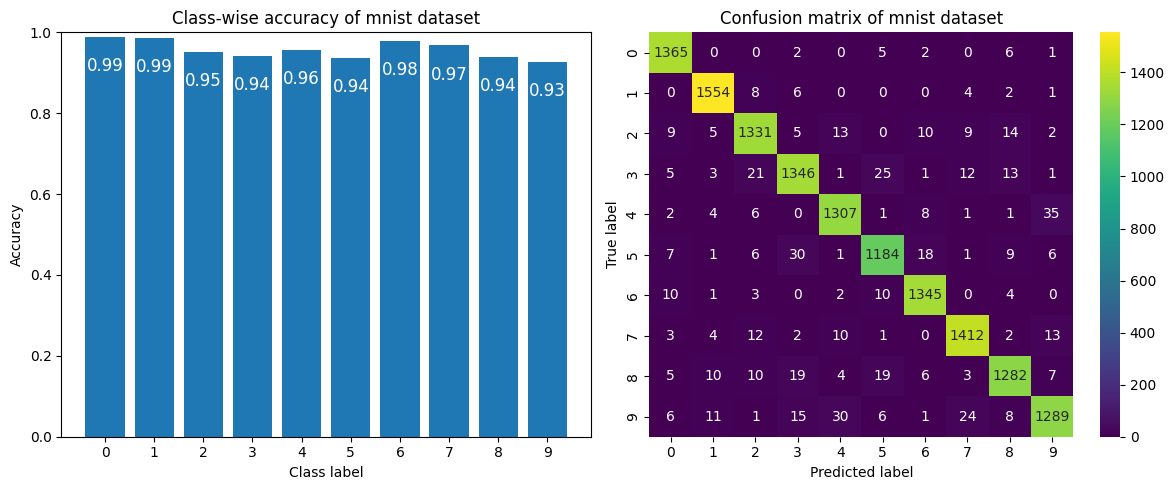

In [17]:
svm_rbf = SVMModel(kernel='rbf', C=10.0)
svm_rbf.run()

両者の結果を比較すると、線形判別関数よりもRBFカーネルを用いた方が分類精度が向上している。つまり、データは10次元空間内での分布は、超平面で分割できるような綺麗な分布とはなっておらず、非線形な判別関数を用いることでより分類精度が向上するような、入り組んだ分布をしているであろうことが予想される。

## Convolutional Neural Network
---
最後にConvolutional Neural Networkを用いてMNISTの分類問題を解いてみた。ここでは２回の畳み込み・マックスプーリングを通過したのち、3つの全結合層を通過する。最終的な出力層のユニット数は10個となるようにしている。

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])
Epoch: 1, loss: 0.1698869358591074
Epoch: 2, loss: 0.04857268615603831
Epoch: 3, loss: 0.0324318979996715
Epoch: 4, loss: 0.02560344153702364
Epoch: 5, loss: 0.019958549227904285
Epoch: 6, loss: 0.016141633110064717
Epoch: 7, loss: 0.013809967965679982
Epoch: 8, loss: 0.012092183471592717
Epoch: 9, loss: 0.00924903346916397
Epoch: 10, loss: 0.00968740852283645
Test Loss: 0.000687, Test Accuracy: 0.989900%


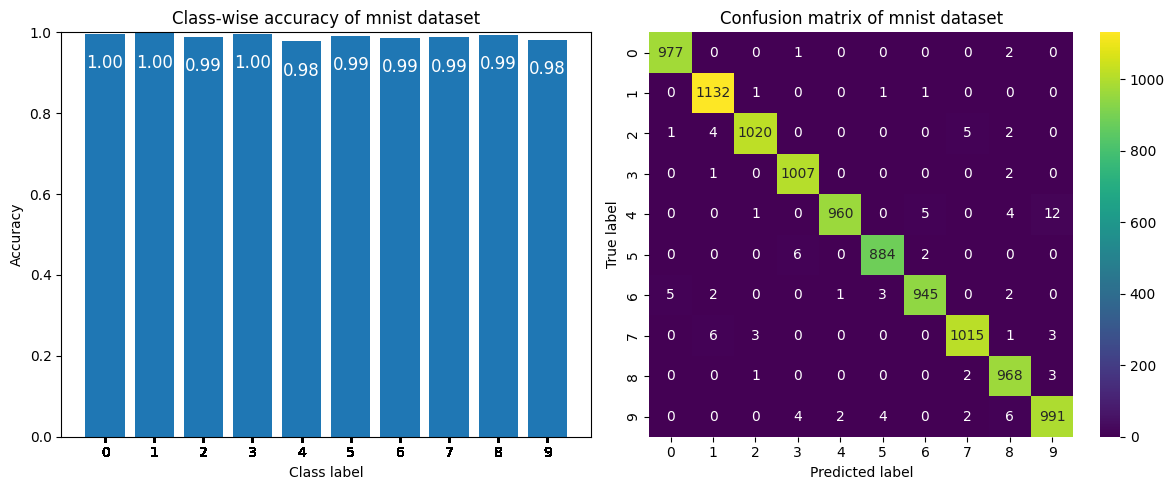

In [21]:
from convolutional_neural_network import CNNClassifier
cnn = CNNClassifier(epochs=10)
cnn.run()

結果は上記のように分類精度はおおよそ99％となり、今回試したRandom Forest、Support Vector Machineよりも高い。単純なCNNでも、恐らく他の2つよりも良い精度になることを想定したうえで実施したものだが、やはりCNNが一番精度が高くなることが確認できた。

## まとめ

---

CNNはRandom ForestやSVMよりも分類精度が高かったが、これはCNNが層を重ねることで、より複雑なパターン認識が可能となっており、また、畳み込みそうを用いることで、画像の局所的な特徴を捉えることが出来ている為と考える。

その一方で、今回のテストではRandom ForestやSVMは画像データをそのまま学習データとして利用している為、画像から抽出された単純なパターンしか学習できていないと考える。もし人間がハンドメイドで優れた特徴量を作ることが出来れば、CNNに伍すルような分類精度を出す事も出来るのかもしれないが、今回のテストでみたように、HOGやGLCMといった広く用いられる特徴量ではCNNに及ばなかった事からわかるように、それは実際的には非常に難しい事である。

ただし、常にCNN(DNN)が教師有り機械学習におけるベストな選択となるわけではなく、それぞれのアルゴリズムに適した問題領域が存在する。

例えば、Random ForestやLightGBMといった決定木をベースにしたモデルの場合、構造化データに対しては、非常に優秀な性能を発揮することが分かっている。

SVMの場合には、データセットが中小規模の場合に適している。データセットが多い場合に計算コストが高くなってしまうことがある。データセットが小さい画像の分類問題などの場合には、SVMを用いることでCNNよりもすくないデータで安定した性能を発揮することが期待できる。